# Proyecto final
## Cálculo de PCA aplicado a compresión de imágenes.

### Equipo 7

## 1. Introducción
En este proyecto, trabajaremos en el análisis de componentes principales para datos de imágenes. PCA es una famosa técnica de reducción de dimensionalidad no supervisada que viene a nuestro rescate cada vez que la maldición de la dimensionalidad nos persigue. Aunado a esto, vamos a calcular las componentes principales haciendo uso del algoritmo de rotaciones de Jacobi para obtener los SVD y a partir de estos los PCA.

Una imagen de color típica se compone de píxeles, muchos píxeles se unen en una matriz para formar una imagen digital. Dicha digital típica se crea apilando matrices de píxeles rojo, azul y verde de intensidades que van de 0 a 255.

## 2. Teoría

### 2.1 Repaso de PCA

Las componentes principales encuentran una proyección lineal de datos en un sistema de base ortogonal que tiene la redundancia mínima y conserva la variación en los datos.
Aplicaciones:
* Identificar la dimensionalidad intrínseca de los datos.
* Representación dimensional más baja de datos con el menor error de reconstrucción.

### 2.2 PCA para reducción de dimensionalidad

* Si los datos viven en un espacio dimensional inferior, entonces algunos de los valores propios en la matriz se establecen en 0.
* Si queremos reducir la dimensionalidad de los datos de $d$ a algunos fijos $k$ elegimos los eigenvectores correspondientes a los $k$ eigenvalor más altos, i.e. las dimensiones que conservan la mayor parte de la varianza en los datos.
* Esta selección también minimiza el error de reconstrucción de datos (por lo que las mejores $k$ dimensiones conducen al mejor error).

### 2.3 Algoritmo PCA

Pasos para realizar el PCA: de una matriz $X\in \mathbb{R}_{N\times a}$ a una matriz $X\in \mathbb{R}_{N\times b}$:

1. Centrar la matriz, substrayendo la media.
2. Calcular la matriz de covarianzas de la matriz centrada $C=\frac{1}{N-1}X^TX$.
3. Calcular los eigenvectores de la matriz de covarianzas.
4. Seleccionar los $m$ eigenvectores correspondientes a los eigenvalores más grandes.

Obtenemos los **Componentes Principales de X** al multiplicar estos eigenvectores por $X_{centrada}^{T}$.

El proceso de PCA identifica aquellas direcciones en las que la varianza es mayor. Como la varianza de una variable se mide en su misma escala elevada al cuadrado, si antes de calcular las componentes no se estandarizan todas las variables para que tengan media 0 y desviación estándar 1, aquellas variables cuya escala sea mayor dominarán al resto. De ahí que sea recomendable estandarizar siempre los datos.

### 2.3.1 Obtención de valores y vectores propios
El número $\sigma$ se denomina valor singular de $A$ si $\sigma=\sqrt{\lambda A^TA}=\sqrt{\lambda AA^T}$ donde: $\lambda A^TA$ y $\lambda AA^T$ es eigenvalor de $A^TA$ y $AA^T$ respectivamente.

### 2.3.2 Uso de rotaciones de Jacobi
"Este método produce una secuencia de transformaciones ortogonales de la forma $J_k^TAJ_k$ con el objetivo de hacer “más diagonal” a la matriz $A\in\mathbb{R}_{n \times n}$.

Si la matriz $A$ es simétrica y $J_0$ es una transformación de rotación de Jacobi, ver transformaciones de rotación, entonces el esquema iterativo:

$$A_{k+1}=(J_0J_1\dots J_k)^TA(J_0J_1\dots J_k)$$
converge a una matriz diagonal en la que se encuentran los eigenvalores de $A$."

#### 2.3.2.1 Algoritmo rotaciones de Jacobi

Dados $A$ simétrica y $tol>0$ definir $A_0=A$, $Q_0=I_n$.

Repetir el siguiente bloque para $k=0,1,2,\dots$

1. Elegir un par de índices $(idx1,idx2)$ según las metodologías vistas en clase,

2. Calcular las entradas $cos(\theta),sin(\theta)$ de la matriz de rotación $J_k$,

3. $A_{k+1}=J^T_kA_kJ_k$,

4. $Q_{k+1}=Q_kJ_k$,

hasta convergencia: satisfacer criterio de paro en el que se utiliza $tol$ y $maxsweeps$.

La matriz $J_k$ se utiliza para eliminar un par de entradas (simétricas) en la matriz $A_k$, esto preserva la simetría de la matriz original. En las columnas de la matriz $Q_k$ se encuentran aproximaciones a los eigenvectores de $A$ y en la diagonal de $A_k$ se tienen aproximaciones a los eigenvalores de $A$.

Una vez analizado todo lo anterior, crearemos las funciones necesarias para llevar a cabo la compresión de imágenes.

In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
from numpy import cov
from math import sqrt

from sklearn.decomposition import PCA

In [3]:
np.set_printoptions(precision=3, suppress=True)

Haremos el cálculo de **eigenvalores** y **eigenvectores** de nuestra matriz $X$ de datos utilizando **método de rotaciones de Jacobi y ordenamiento cíclico por renglones.**

Se toman las funciones definidas en la nota [2.3 Algoritmos y aplicaciones de eigenvalores y eigenvectores de una matriz](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.3/Algoritmos_y_aplicaciones_de_eigenvalores_eigenvectores_de_una_matriz.html) del libro de Optimización.

In [4]:
# función de signo
def sign(x):
    """
    Helper function for computing sign of real number x.
    """
    if x >= 0:
        return 1
    else:
        return -1

In [5]:
# función que calcula entradas de matriz de rotación Jacobi
def compute_cos_sin_Jacobi_rotation(Ak, idx1, idx2):
    """
    Helper function for computing entries of Jacobi rotation.
    Args:
        Ak (numpy ndarray): Matrix of iteration k in Jacobi rotation method.
        idx1 (int): index for rows in Jacobi rotation matrix.
        idx2 (int): index for columns in Jacobi rotation matrix.
    Returns:
        c (float): value of cos of theta for Jacobi rotation matrix.
        s (float): value of sin of theta for Jacobi rotation matrix.
    """
    if np.abs(Ak[idx1, idx2]) > np.finfo(float).eps:
        tau = (Ak[idx2, idx2] - Ak[idx1, idx1]) / (2 * Ak[idx1, idx2])
        t_star = sign(tau) / (np.abs(tau) + np.sqrt(1 + tau ** 2))
        c = 1 / np.sqrt(1 + t_star ** 2)
        s = c * t_star
    else:  # no rotation is performed
        c = 1
        s = 0

    return (c, s)

In [6]:
# función que calcula matriz de rotación Jacobi
def compute_Jacobi_rotation(Ak, idx1, idx2):
    """
    Compute Jacobi rotation matrix.
    Args:
        Ak (numpy ndarray): Matrix of iteration k in Jacobi rotation method.
        idx1 (int): index for rows in Jacobi rotation matrix.
        idx2 (int): index for columns in Jacobi rotation matrix.
    Returns:
        J (numpy ndarray): Jacobi rotation matrix.
    """
    c,s = compute_cos_sin_Jacobi_rotation(Ak, idx1, idx2)
    m,n = Ak.shape
    J = np.eye(m)
    J[idx1, idx1] = J[idx2, idx2] = c
    J[idx1, idx2] = s
    J[idx2, idx1] = -s
    return J

Definimos las funciones para "diagonalizar" la matriz $X^{T}X$ con rotaciones de Jacobi a través del método de ordenamiento cíclico por renglones.

Primero, definimos funciones auxiliares `off()` y `max_sweeps()` para el criterio de paro

In [7]:
def off(A):
    """
        Find the quantity "off(A)" Frobenius norm of 𝐴 without the diagonal..
        Args:
            A (numpy ndarray): Matrix to calculate "off(A)".
        Returns:
            scalar value(float): value of function off(A).
        """
    A_k = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], -1)

    return np.linalg.norm(A_k, 'fro')

In [8]:
def max_sweeps(n):
    """
            Find the maximum number of sweeps to iterate in Jacobi's rotation algorithm.
            Args:
                n (int value): It corresponds to the maximum number of entries
            in the matrix that form the upper triangular part of 𝐴 without
            counting the diagonal that are assumed to be different from zero..
            Returns:
                max_sweeps(Int): Maximum number of sweeps.
    """
    max_sw = (n * (n - 1)) / 2

    return max_sw

Definimos función que realiza las iteraciones de Jacobi:

In [36]:
def jacobi_iteration(a, tol=1.0e-8):
    """
            Jacobi rotations function for symmetric matrices with repeated elimination
            Args:
                a (numpy ndarray): Matrix to compute Jacobi rotation.
                tol (float): a small, positive amount (commonly less than or equal to 10−8).
            Returns:
                a_k (numpy ndarray): vector with eigenvalues of A.
                q_k (numpy ndarray): Matrix with eigenvectors of A.
    """

    # Realizamos una copia de A = A_k
    a_k = a.copy()

    # se define numero de dimension n basado en columnas
    # las entradas totales del triangulo superiores de A
    n = a_k.shape[1]

    # Definimos matriz identidad de x que generara vectores
    q_k = np.identity(n)

    # iniciamos contador de sweeps
    sweeps = 1
    # se calcula el valor maximo de sweeps
    max_sw = max_sweeps(n)

    # se calcula el Off inicial
    off_val = off(a_k)
    # se calcula tolerancia inicial
    tolerancia = tol * np.linalg.norm(a_k, 'fro')

    # se extraen los indices del triangulo sup de x
    tri_sup = np.triu_indices(n, 1)

    # se unen los indices en un solo array para hacer el loop de entradas de rotacion
    index_tri = np.column_stack((tri_sup[0], tri_sup[1]))

    print("Max_Sweeps {}".format(max_sw))
    print("------------------------\n\n")

    while off_val > tolerancia and sweeps < max_sw:

        print("Sweeps {}".format(sweeps))
        print("------------------------")

        for i in index_tri:
            # print("idx_1 = {}".format(i[0]))
            # print("idx_2 = {}".format(i[1]))

            j = compute_Jacobi_rotation(a_k, i[0], i[1])
            a_k = j.T @ a_k @ j
            q_k = q_k @ j

        # Se calcula nueva off y se imprime
        off_val = off(a_k)
#        print("Off(x_k) = {}".format(off_val))
        # se calcula nueva tolerancia y se imprime
        tolerancia = tol * np.linalg.norm(a_k, 'fro')
#        print("tolerancia = {}\n".format(tolerancia))

#        print("La transformación de x_k queda como:")
#        print(a_k)
#        print("\nLa matriz q_k queda como:")
#        print(q_k)
#        print("------------------------\n\n")

        sweeps += 1

    return np.diag(a_k), q_k

Ahora realizaremos el cálculo con una función que implementamos y que nos ayuda a calcular las PCA, basándonos en el método de Jacobi

Recordamos que las "direcciones principales están dadas por las columnas de $V$ (salvo signos positivos o negativos)", y que las "**componentes principales están dadas por la multiplicación matricial de $XV$** (salvo signos positivos o negativos)"

Siguiendo un método más directo y que también funciona, con base en nota [2.4 del libro de Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.4/Valores_vectores_singulares_y_algoritmos_para_calcular_la_SVD.html). Podemos obtener PCA multiplicando $X_{centrada}$ por $V$ (obtenida a partir de $Q_k$ resultante de aplicar Jacobi a $X^{T}X$).

In [37]:
def returnPCA(x, method):
    """
                Return PCA function to calculate the principal components of a matrix
                Args:
                    x (numpy ndarray): Matrix to compute PCA
                    method (str): string that indicates the method to be used for the
                                  approximation of eigenvalues and eigenvectors,
                                  "jacobi" for the jacobi_iteration method or "linalg" for the numpy method
                Returns:
                    x_k (numpy ndarray): vector with eigenvalues of x
                    q_k (numpy ndarray): Matrix with components of x
                    pca (numpy ndarray): Matrix with principal components scores of x
    """

    # se centra x
    x_c = x - x.mean(axis=0)

    # se calcula la covarianza de la matriz centrada transpuesta x_c.T que resulta en v
    v = np.cov(x_c.T)
    # se inicializan las variables a retornar
    x_k = np.empty(x_c.shape)
    q_k = np.empty(x_c.shape)

    # se calculan los eigenvalores y eigen vectores se puede utilizar
    # el metodo de jacobi_iteration o linalg de numpy
    if method == "jacobi":
        x_k, q_k = jacobi_iteration(v, tol=1.0e-8)
    elif method == "linalg":
        x_k, q_k = np.linalg.eig(v)
    else:
        print("no method found")

    # Obtenemos los Scores Componentes Principales de x al multiplicar .dot q_k.T por x_c.T centrada .
    pca = q_k.T.dot(x_c.T)
    # retorna pca.T
    return x_k, q_k, pca.T

## 3. Principal Component Analysis for Image Data Compression

Aparte de las múltiples aplicaciones de PCA, otra aplicación interesante es la compresión de imágenes. Echemos un vistazo a cómo podemos lograr esto con Python.

In [11]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
# Importing required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg

### 3.1 Cargando la imagen
Vamos a usar una foto de una de nuestras mascotas. *idea meter una imágen bien hecha de Capi*


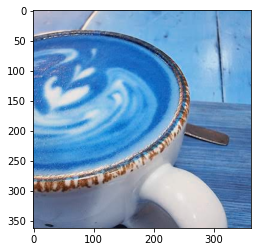

In [16]:
# Loading the image
img_path = '/datos/otono-2021/optimizacion/practicas/proyecto-final/img/cafe_baja.jpeg'
img = cv2.imread(img_path)
plt.imshow(img)

Veamos el tamaño de la imagen

In [17]:
img.shape

(362, 362, 3)

### 3.2 División de la imagen en formato RGB

Sabemos que una imagen digital en color es una combinación de matrices R, G y B (rojo, verde, azul) apiladas unas sobre otras. Es necesario dividir cada canal de la imagen y extraer los componentes principales de cada uno de ellos.

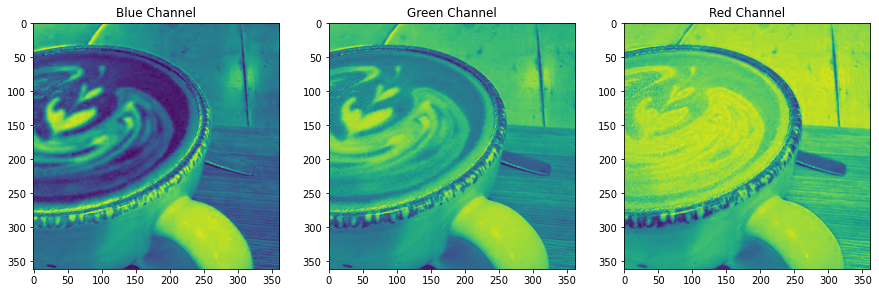

In [18]:
blue,green,red = cv2.split(img)
# Veámoslo en sus diferentes matices
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

Escalamos los datos

In [19]:
df_blue = blue/255
df_green = green/255
df_red = red/255

# PCA Jacobi

In [21]:
df_blue

array([[0.745, 0.745, 0.745, ..., 0.353, 0.384, 0.384],
       [0.745, 0.745, 0.745, ..., 0.361, 0.373, 0.373],
       [0.737, 0.737, 0.737, ..., 0.365, 0.369, 0.369],
       ...,
       [0.369, 0.373, 0.376, ..., 0.267, 0.239, 0.239],
       [0.349, 0.349, 0.392, ..., 0.224, 0.282, 0.231],
       [0.271, 0.278, 0.329, ..., 0.318, 0.373, 0.322]])

In [22]:
evalues, q_k, pca_k = returnPCA(df_blue,"jacobi")

Max_Sweeps 65341.0
------------------------


Sweeps 1
------------------------
Off(x_k) = 2.6292145113797756
tolerancia = 6.028006077706571e-08

La transformación de x_k queda como:
[[ 3.611  0.001 -0.667 ... -0.001 -0.002 -0.   ]
 [ 0.001  0.     0.001 ... -0.     0.     0.   ]
 [-0.667  0.001  3.41  ...  0.001  0.004  0.   ]
 ...
 [-0.001 -0.     0.001 ...  0.     0.    -0.   ]
 [-0.002  0.     0.004 ...  0.     0.     0.   ]
 [-0.     0.     0.    ... -0.     0.     0.   ]]

La matriz q_k queda como:
[[ 0.1   -0.4   -0.06  ... -0.018  0.01   0.002]
 [ 0.099  0.724 -0.054 ... -0.011  0.009  0.009]
 [ 0.097 -0.507 -0.039 ... -0.001  0.004  0.006]
 ...
 [-0.004  0.002  0.019 ...  0.277  0.022 -0.059]
 [-0.003  0.004  0.017 ... -0.038  0.189 -0.293]
 [-0.003  0.     0.018 ...  0.036  0.036  0.285]]
------------------------


Sweeps 2
------------------------
Off(x_k) = 0.7540529125836269
tolerancia = 6.028006077706605e-08

La transformación de x_k queda como:
[[ 4.505 -0.001 -0.038 ...

In [38]:
evalues_g, q_k_g, pca_k_g = returnPCA(df_green,"jacobi")

Max_Sweeps 65341.0
------------------------


Sweeps 1
------------------------
Off(x_k) = 1.3835916911830315
Sweeps 2
------------------------
Off(x_k) = 0.21846324476889661
Sweeps 3
------------------------
Off(x_k) = 0.03613270418886391
Sweeps 4
------------------------
Off(x_k) = 0.007264251944120142
Sweeps 5
------------------------
Off(x_k) = 0.0005865960375565185
Sweeps 6
------------------------
Off(x_k) = 0.00010623002664508545
Sweeps 7
------------------------
Off(x_k) = 2.0331597037108153e-05
Sweeps 8
------------------------
Off(x_k) = 3.4514487412322084e-06
Sweeps 9
------------------------
Off(x_k) = 6.205774846938957e-07
Sweeps 10
------------------------
Off(x_k) = 1.734760910492126e-07
Sweeps 11
------------------------
Off(x_k) = 4.990318381531162e-08
Sweeps 12
------------------------
Off(x_k) = 9.298123312311304e-09


In [39]:
evalues_r, q_k_r, pca_k_r = returnPCA(df_red,"jacobi")

Max_Sweeps 65341.0
------------------------


Sweeps 1
------------------------
Off(x_k) = 1.211871034575815
Sweeps 2
------------------------
Off(x_k) = 0.3246660909838847
Sweeps 3
------------------------
Off(x_k) = 0.09920868766221318
Sweeps 4
------------------------
Off(x_k) = 0.0032901612733363464
Sweeps 5
------------------------
Off(x_k) = 0.0007300432865510289
Sweeps 6
------------------------
Off(x_k) = 0.0001347160798816803
Sweeps 7
------------------------
Off(x_k) = 1.950906435574306e-05
Sweeps 8
------------------------
Off(x_k) = 3.106440721759077e-06
Sweeps 9
------------------------
Off(x_k) = 7.588682896505997e-07
Sweeps 10
------------------------
Off(x_k) = 1.9212477499232772e-07
Sweeps 11
------------------------
Off(x_k) = 3.1921122795528564e-08


In [25]:
print(evalues)

[4.509 0.    2.956 0.001 0.    0.001 0.    0.392 2.233 0.    0.001 0.
 0.001 0.    0.    0.001 1.003 0.    0.738 0.    0.53  0.    0.012 0.
 0.326 0.    0.    0.188 0.    0.173 0.    0.    0.111 0.092 0.16  0.
 0.    0.    0.    0.066 0.    0.    0.131 0.072 0.    0.    0.    0.06
 0.116 0.    0.    0.    0.089 0.    0.    0.085 0.001 0.    0.    0.
 0.051 0.043 0.    0.055 0.    0.048 0.    0.    0.039 0.    0.    0.
 0.03  0.    0.035 0.022 0.    0.024 0.    0.    0.001 0.031 0.    0.015
 0.021 0.03  0.    0.    0.    0.    0.    0.027 0.002 0.    0.    0.019
 0.017 0.    0.    0.016 0.    0.011 0.    0.013 0.017 0.    0.    0.001
 0.    0.    0.    0.013 0.013 0.    0.    0.    0.009 0.011 0.005 0.009
 0.    0.    0.    0.01  0.01  0.    0.    0.    0.009 0.    0.    0.
 0.01  0.    0.    0.008 0.    0.    0.005 0.    0.002 0.008 0.    0.007
 0.007 0.007 0.    0.    0.001 0.    0.006 0.    0.005 0.    0.    0.
 0.    0.    0.001 0.    0.006 0.006 0.006 0.    0.    0.002 0.006 0.
 0.

In [40]:
evalues_g

array([2.791, 0.   , 1.723, 0.   , 0.   , 0.   , 0.   , 0.775, 0.062,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.497, 0.   ,
       0.294, 0.   , 0.455, 0.   , 0.   , 0.187, 0.14 , 0.   , 0.   ,
       0.   , 0.072, 0.   , 0.2  , 0.   , 0.155, 0.   , 0.   , 0.   ,
       0.   , 0.129, 0.   , 0.067, 0.103, 0.   , 0.083, 0.   , 0.   ,
       0.   , 0.   , 0.121, 0.044, 0.031, 0.04 , 0.   , 0.   , 0.06 ,
       0.   , 0.036, 0.046, 0.   , 0.027, 0.   , 0.001, 0.006, 0.034,
       0.027, 0.029, 0.004, 0.024, 0.019, 0.   , 0.   , 0.022, 0.   ,
       0.015, 0.   , 0.   , 0.   , 0.021, 0.017, 0.001, 0.   , 0.014,
       0.005, 0.015, 0.011, 0.   , 0.   , 0.002, 0.014, 0.002, 0.015,
       0.   , 0.   , 0.013, 0.011, 0.   , 0.012, 0.01 , 0.009, 0.   ,
       0.002, 0.   , 0.   , 0.   , 0.008, 0.   , 0.011, 0.   , 0.012,
       0.   , 0.   , 0.   , 0.   , 0.009, 0.   , 0.   , 0.005, 0.   ,
       0.   , 0.01 , 0.007, 0.005, 0.   , 0.   , 0.008, 0.008, 0.   ,
       0.007, 0.005,

In [41]:
evalues_r

array([3.861, 0.   , 1.039, 0.001, 0.   , 0.   , 0.   , 0.18 , 1.373,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.044, 0.   ,
       0.467, 0.   , 0.248, 0.   , 0.   , 0.298, 0.106, 0.   , 0.   ,
       0.238, 0.   , 0.   , 0.16 , 0.   , 0.131, 0.   , 0.   , 0.   ,
       0.072, 0.   , 0.   , 0.081, 0.   , 0.   , 0.066, 0.   , 0.034,
       0.046, 0.   , 0.043, 0.   , 0.   , 0.069, 0.   , 0.   , 0.054,
       0.   , 0.037, 0.001, 0.027, 0.   , 0.   , 0.03 , 0.027, 0.005,
       0.   , 0.022, 0.026, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.014, 0.   , 0.   , 0.023, 0.   , 0.003, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.009, 0.   , 0.   , 0.017, 0.   , 0.018, 0.   ,
       0.   , 0.001, 0.   , 0.019, 0.   , 0.   , 0.021, 0.   , 0.   ,
       0.015, 0.   , 0.   , 0.011, 0.015, 0.003, 0.   , 0.   , 0.004,
       0.013, 0.   , 0.   , 0.   , 0.002, 0.012, 0.   , 0.014, 0.   ,
       0.   , 0.012, 0.011, 0.009, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.003,

### Varianza explicada

In [43]:
total_evalues_b = sum(evalues)
var_exp_b = [(i/total_evalues_b) for i in sorted(evalues, reverse=True)]

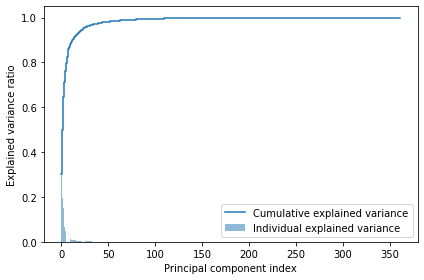

In [44]:
# Plot the explained variance against cumulative explained variance
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

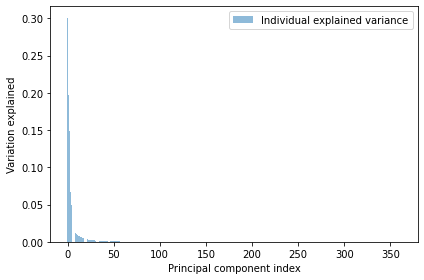

In [45]:
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

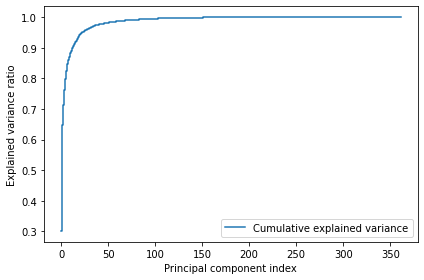

In [46]:
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Podemos ver que con 50 componentes principales ya se explica más del 95%

In [47]:
cum_sum_exp

array([0.301, 0.498, 0.647, 0.714, 0.763, 0.799, 0.825, 0.847, 0.859,
       0.871, 0.882, 0.89 , 0.898, 0.905, 0.912, 0.918, 0.923, 0.928,
       0.933, 0.937, 0.94 , 0.944, 0.947, 0.95 , 0.952, 0.955, 0.957,
       0.959, 0.961, 0.963, 0.964, 0.966, 0.967, 0.968, 0.969, 0.971,
       0.972, 0.973, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.978,
       0.979, 0.98 , 0.98 , 0.981, 0.981, 0.982, 0.982, 0.983, 0.983,
       0.984, 0.984, 0.985, 0.985, 0.985, 0.986, 0.986, 0.987, 0.987,
       0.987, 0.988, 0.988, 0.988, 0.989, 0.989, 0.989, 0.989, 0.99 ,
       0.99 , 0.99 , 0.99 , 0.991, 0.991, 0.991, 0.991, 0.992, 0.992,
       0.992, 0.992, 0.992, 0.993, 0.993, 0.993, 0.993, 0.993, 0.993,
       0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.995, 0.995,
       0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.996, 0.996, 0.996,
       0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.997, 0.997,
       0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997,
       0.997, 0.998,

con 72 componentes (de 364) se explica el 99% 

**Canal verde**

In [48]:
total_evalues_g = sum(evalues_g)
var_exp_g = [(i/total_evalues_g) for i in sorted(evalues_g, reverse=True)]

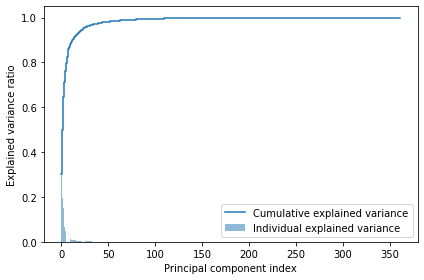

In [49]:
# Plot the explained variance against cumulative explained variance
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

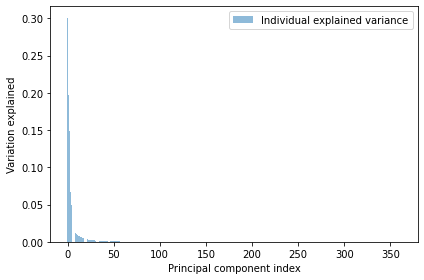

In [50]:
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

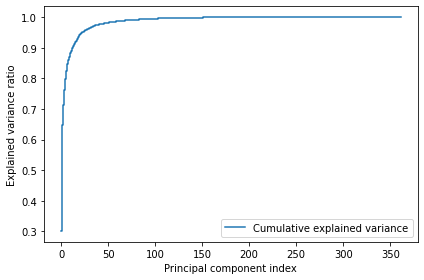

In [51]:
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [53]:
# Para ver con cuantos componentes se explica
cum_sum_exp

array([0.301, 0.498, 0.647, 0.714, 0.763, 0.799, 0.825, 0.847, 0.859,
       0.871, 0.882, 0.89 , 0.898, 0.905, 0.912, 0.918, 0.923, 0.928,
       0.933, 0.937, 0.94 , 0.944, 0.947, 0.95 , 0.952, 0.955, 0.957,
       0.959, 0.961, 0.963, 0.964, 0.966, 0.967, 0.968, 0.969, 0.971,
       0.972, 0.973, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.978,
       0.979, 0.98 , 0.98 , 0.981, 0.981, 0.982, 0.982, 0.983, 0.983,
       0.984, 0.984, 0.985, 0.985, 0.985, 0.986, 0.986, 0.987, 0.987,
       0.987, 0.988, 0.988, 0.988, 0.989, 0.989, 0.989, 0.989, 0.99 ,
       0.99 , 0.99 , 0.99 , 0.991, 0.991, 0.991, 0.991, 0.992, 0.992,
       0.992, 0.992, 0.992, 0.993, 0.993, 0.993, 0.993, 0.993, 0.993,
       0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.995, 0.995,
       0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.996, 0.996, 0.996,
       0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.997, 0.997,
       0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997,
       0.997, 0.998,

**Canal rojo**

In [55]:
total_evalues_r = sum(evalues_r)
var_exp_r = [(i/total_evalues_r) for i in sorted(evalues_r, reverse=True)]

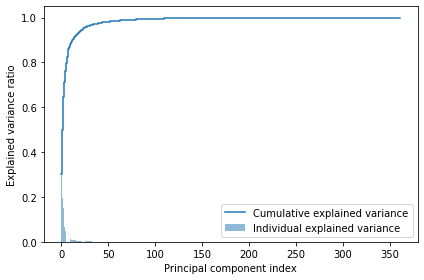

In [56]:
# Plot the explained variance against cumulative explained variance
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

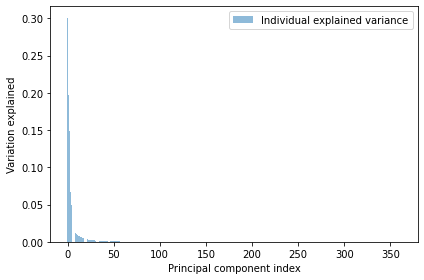

In [57]:
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

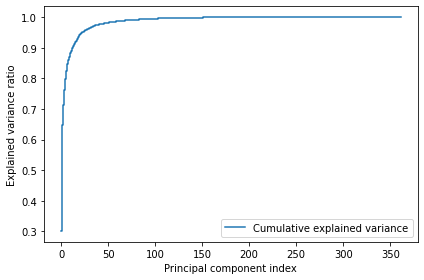

In [58]:
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [59]:
# Para ver con cuantos componentes se explica
cum_sum_exp

array([0.301, 0.498, 0.647, 0.714, 0.763, 0.799, 0.825, 0.847, 0.859,
       0.871, 0.882, 0.89 , 0.898, 0.905, 0.912, 0.918, 0.923, 0.928,
       0.933, 0.937, 0.94 , 0.944, 0.947, 0.95 , 0.952, 0.955, 0.957,
       0.959, 0.961, 0.963, 0.964, 0.966, 0.967, 0.968, 0.969, 0.971,
       0.972, 0.973, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.978,
       0.979, 0.98 , 0.98 , 0.981, 0.981, 0.982, 0.982, 0.983, 0.983,
       0.984, 0.984, 0.985, 0.985, 0.985, 0.986, 0.986, 0.987, 0.987,
       0.987, 0.988, 0.988, 0.988, 0.989, 0.989, 0.989, 0.989, 0.99 ,
       0.99 , 0.99 , 0.99 , 0.991, 0.991, 0.991, 0.991, 0.992, 0.992,
       0.992, 0.992, 0.992, 0.993, 0.993, 0.993, 0.993, 0.993, 0.993,
       0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.995, 0.995,
       0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.996, 0.996, 0.996,
       0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.997, 0.997,
       0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997,
       0.997, 0.998,

**Pendiente, hacer función para seleccionar no componentes, al 95, 97 y 99%?**

### Pendiente inverse_transform

# PCA sklearn
### 3.3 Ajustar y transformar los datos en PCA
Como vimos, cada canal tiene 485 dimensiones, y ahora consideraremos solo 50 dimensiones para PCA y ajustaremos y transformaremos los datos y verificaremos cuánta varianza se explica después de reducir los datos a 50 dimensiones.

In [17]:
pca_b = PCA(n_components=50)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=50)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=50)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

Veamos el tamaño de las nuevas matrices

In [18]:
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(4000, 50)
(4000, 50)
(4000, 50)


Eso es lo esperado. Comprobemos la suma de las relaciones de varianza explicadas de los 50 componentes del PCA (es decir, los 50 valores propios más dominados) para cada canal.

# Nota Luz Hacer una función de la varianza explicada complementaria a nuestra función PCA

In [19]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.9675498167639569
Green Channel: 0.9634276118798603
Red Channel  : 0.9669918473148975


Con 50 componentes principales tenemos una varianza explicada de __
Analicemos una gráfica con las PCA 

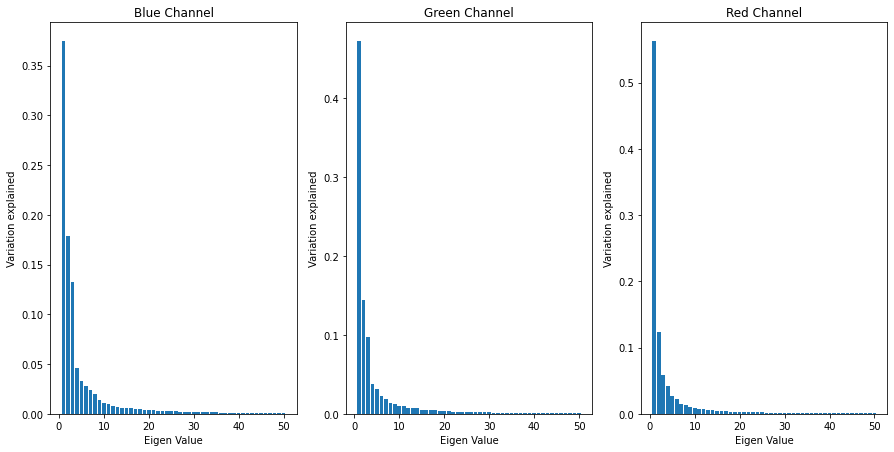

In [20]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_r.explained_variance_ratio_)
plt.show()

### 3.4 Recontrucción de la imagen

Ahora que tenemos una reducción de dimensionalidad usando nuestra función PCA, sabemos que tenemos un x% de varianza explicada, ahora visualizaremos la imagen nuevamente y para eso, primero tenemos que invertir la transformación de los datos y luego fusionar los datos de los 3 canales en uno.

In [21]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(4000, 3000) (4000, 3000) (4000, 3000)


# Nota Luz función para regresar PCA acorde a esta ref: https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

Podemos transformar los datos a la forma original aun con los canales separados por color. Fusionaremos todos los canales en uno usando la función `cv2.merge` e imprimiremos la forma final:

In [22]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(4000, 3000, 3)


In [23]:
img_reduced

array([[[0.906, 0.804, 0.819],
        [0.912, 0.804, 0.818],
        [0.92 , 0.805, 0.816],
        ...,
        [0.361, 0.385, 0.409],
        [0.368, 0.39 , 0.416],
        [0.374, 0.393, 0.422]],

       [[0.905, 0.804, 0.818],
        [0.91 , 0.804, 0.818],
        [0.918, 0.804, 0.816],
        ...,
        [0.361, 0.386, 0.41 ],
        [0.368, 0.39 , 0.417],
        [0.374, 0.394, 0.423]],

       [[0.905, 0.805, 0.819],
        [0.91 , 0.805, 0.818],
        [0.918, 0.805, 0.816],
        ...,
        [0.36 , 0.386, 0.41 ],
        [0.367, 0.391, 0.417],
        [0.373, 0.394, 0.423]],

       ...,

       [[0.435, 0.604, 0.739],
        [0.436, 0.606, 0.739],
        [0.437, 0.611, 0.738],
        ...,
        [0.444, 0.543, 0.727],
        [0.447, 0.546, 0.728],
        [0.447, 0.547, 0.728]],

       [[0.446, 0.602, 0.741],
        [0.447, 0.605, 0.74 ],
        [0.448, 0.61 , 0.74 ],
        ...,
        [0.47 , 0.569, 0.757],
        [0.471, 0.571, 0.758],
        [0.472,

Ahora veamos las dos imágenes lado a lado

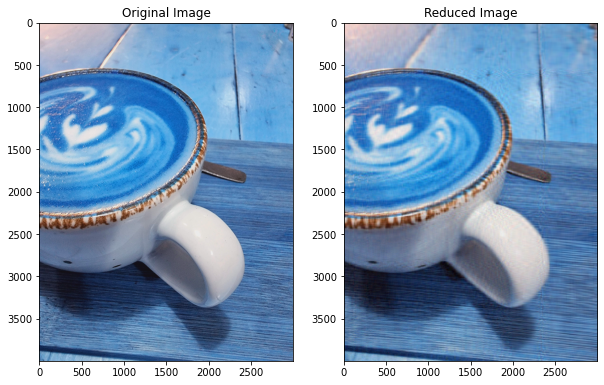

In [26]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
#plt.imshow(img_reduced)
plt.imshow((img_reduced * 255).astype(np.uint8)) # reconvertir para volver a graficar
plt.show()

Como nuestro ojo humano puede apreciar, la imagen comprimida es muy similar a la original, aunque hemos reducido la dimensión a solo 50 desde 485. esto significa que ahora la imagen reducida será procesada mucho más rápido por la computadora.

## 4. Conclusión
Hemos visto cómo podemos usar las rotaciones de Jacobi para crear nuestra propia función para obtener las PCA y a partir de estas poder reducir la dimensión de una imagen en color dividiéndola en 3 canales y luego reconstruyéndola para su visualización.


## Referencias

* [1] [2.3 del libro de Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.3/Algoritmos_y_aplicaciones_de_eigenvalores_eigenvectores_de_una_matriz.html) 
* [2] [2.4 del libro de Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.4/Valores_vectores_singulares_y_algoritmos_para_calcular_la_SVD.html)
* [3] [Singular Value Decomposition](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)
* [4] [How to Calculate Principal Component Analysis (PCA) from Scratch in Python](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/)
* [5] [numpy.column_stack](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html#numpy.column_stack)
* [6] [numpy.triu_indices](https://numpy.org/doc/stable/reference/generated/numpy.triu_indices.html)
* [7] [Análisis de Componentes Principales](https://www.cienciadedatos.net/documentos/35_principal_component_analysis)
* [8] [Dimensionality reduction of color image using PCA](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118)
* [9] [Principal Component Analysis (PCA)and Singular Value Decomposition (SVD)](https://people.cs.pitt.edu/~milos/courses/cs3750-Fall2014/lectures/class9.pdf)
* [10] [How to reverse PCA and reconstruct original variables from several principal components?](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)